# Facial Expression Detection
## By Sergei Issaev

### Introduction
Hello everyone! Today I will be using a dataset of human faces, provided by Sulthan Khan (https://www.kaggle.com/sulthankhan/facial-expression-recognition), to build a human expression classifier. Although the dataset is large, the images are relatively small - 48 by 48 pixels, which will make it more difficult to attain a high classification accuracy. Let's get started!

### Import Libraries

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import PIL

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)

### Load in the Data

In [2]:
# Data augmentation
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(48, padding=8, padding_mode='reflect'),
     #T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.Resize((48, 48)),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
     T.Normalize(*imagenet_stats,inplace=True), 
    #T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
     T.Resize((48, 48)), 
    T.ToTensor(), 
     T.Normalize(*imagenet_stats)
])

In [3]:

dataset = ImageFolder(root='/kaggle/input/facial-expression-recognition/train/')

dataset_size = len(dataset)
dataset_size

28708

In [4]:
testdataset = ImageFolder(root='/kaggle/input/facial-expression-recognition/test/', transform = valid_tfms)

testdataset_size = len(testdataset)
testdataset_size

7178

### EDA

In [5]:
dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

Random image number  23654
Class label sad


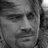

In [6]:
random_image = np.random.randint(0, 28708)
print('Random image number ', random_image)
print('Class label', dict[dataset[random_image][1]])
dataset[random_image][0]

Random image number  15795
Class label neutral


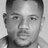

In [7]:
random_image = np.random.randint(0, 28708)
print('Random image number ', random_image)
print('Class label', dict[dataset[random_image][1]])
dataset[random_image][0]

Random image number  860
Class label angry


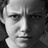

In [8]:
random_image = np.random.randint(0, 28708)
print('Random image number ', random_image)
print('Class label', dict[dataset[random_image][1]])
dataset[random_image][0]

In [9]:
classes = dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
num_classes = len(dataset.classes)
num_classes

7

### Perform Train-Test Split

In [11]:
val_size = 1000
train_size = len(dataset) - val_size

train_df, val_df = random_split(dataset, [train_size, val_size])
len(train_df), len(val_df)

(27708, 1000)

In [12]:
val_df.dataset.transform = valid_tfms

train_df.dataset.transform = train_tfms

In [13]:
batch_size = 64

train_dl = DataLoader(train_df, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_df, batch_size*2, 
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(testdataset, batch_size*2, 
                    num_workers=2, pin_memory=True)

images.shape: torch.Size([64, 3, 48, 48])


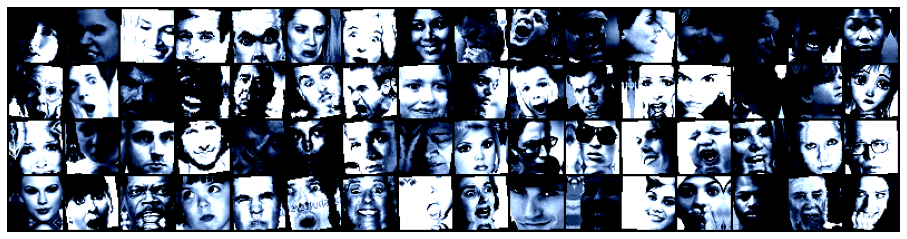

In [14]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### Define the Models

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class CnnModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.wide_resnet101_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 7)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
model = to_device(CnnModel2(), device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/checkpoints/wide_resnet101_2-32ee1156.pth


In [21]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 48, 48])
out.shape: torch.Size([64, 7])
out[0]: tensor([0.4361, 0.2943, 0.3980, 0.7549, 0.4850, 0.3779, 0.3846],
       device='cuda:0', grad_fn=<SelectBackward>)


In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Train the Model

In [23]:
# Set search to a larger number to test out more hyperparameters
search = 1

In [24]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.9748749732971191, 'val_acc': 0.06723257154226303}]

In [25]:
epochs = np.random.randint(2, 25)
max_lr = np.random.choice([5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6])
grad_clip = np.random.choice([0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
weight_decay = np.random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
opt_func = torch.optim.Adam
print('epoch = ', epochs, 'lr = ', max_lr, 'grad is ', grad_clip, 'weights = ', weight_decay)

epoch =  16 lr =  0.005 grad is  0.1 weights =  0.0001


In [26]:
torch.cuda.empty_cache()


history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00069, train_loss: 1.7020, val_loss: 1.7124, val_acc: 0.3978
Epoch [1], last_lr: 0.00198, train_loss: 1.7552, val_loss: 1.8125, val_acc: 0.2124
Epoch [2], last_lr: 0.00352, train_loss: 1.7637, val_loss: 1.7927, val_acc: 0.2782
Epoch [3], last_lr: 0.00468, train_loss: 1.7200, val_loss: 1.7673, val_acc: 0.3120
Epoch [4], last_lr: 0.00500, train_loss: 1.7124, val_loss: 1.7763, val_acc: 0.3229
Epoch [5], last_lr: 0.00486, train_loss: 1.6981, val_loss: 1.7597, val_acc: 0.3226
Epoch [6], last_lr: 0.00454, train_loss: 1.6943, val_loss: 1.6907, val_acc: 0.3800
Epoch [7], last_lr: 0.00406, train_loss: 1.6841, val_loss: 1.7295, val_acc: 0.3543
Epoch [8], last_lr: 0.00346, train_loss: 1.6759, val_loss: 1.7180, val_acc: 0.3513
Epoch [9], last_lr: 0.00278, train_loss: 1.6617, val_loss: 1.7018, val_acc: 0.3906
Epoch [10], last_lr: 0.00208, train_loss: 1.6524, val_loss: 1.6525, val_acc: 0.4322
Epoch [11], last_lr: 0.00142, train_loss: 1.6425, val_loss: 1.6478, val_acc: 0.4373
Ep

In [27]:
for j in range(search):
    model = to_device(CnnModel2(), device)
    history = [evaluate(model, val_dl)]
    print(history)
    epochs = np.random.randint(2, 25)
    max_lr = np.random.choice([5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6])
    grad_clip = np.random.choice([0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
    weight_decay = np.random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
    opt_func = torch.optim.Adam
    print('epoch = ', epochs, 'lr = ', max_lr, 'grad is ', grad_clip, 'weights = ', weight_decay)
    torch.cuda.empty_cache()


    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                 grad_clip=grad_clip, 
                                 weight_decay=weight_decay, 
                                 opt_func=opt_func)

[{'val_loss': 1.9552843570709229, 'val_acc': 0.1162109375}]
epoch =  8 lr =  0.001 grad is  0.3 weights =  1e-05
Epoch [0], last_lr: 0.00039, train_loss: 1.7241, val_loss: 1.6684, val_acc: 0.4169
Epoch [1], last_lr: 0.00094, train_loss: 1.7210, val_loss: 1.7704, val_acc: 0.3420
Epoch [2], last_lr: 0.00097, train_loss: 1.7196, val_loss: 1.8145, val_acc: 0.2478
Epoch [3], last_lr: 0.00081, train_loss: 1.6807, val_loss: 1.6743, val_acc: 0.3835
Epoch [4], last_lr: 0.00056, train_loss: 1.6513, val_loss: 1.6332, val_acc: 0.4607
Epoch [5], last_lr: 0.00028, train_loss: 1.6198, val_loss: 1.6114, val_acc: 0.4642
Epoch [6], last_lr: 0.00008, train_loss: 1.5954, val_loss: 1.5812, val_acc: 0.4983
Epoch [7], last_lr: 0.00000, train_loss: 1.5794, val_loss: 1.5927, val_acc: 0.4903


In [28]:
for j in range(search):
    model = to_device(CnnModel2(), device)
    history = [evaluate(model, val_dl)]
    print(history)
    epochs = np.random.randint(12,24)
    max_lr = np.random.choice([ 5e-3, 1e-4, 5e-4, 1e-5, 5e-5])
    grad_clip = np.random.choice([0.2, 0.15, 0.1, 0.05])
    weight_decay = np.random.choice([ 5e-3, 1e-4, 5e-4, 1e-5])
    opt_func = torch.optim.Adam
    print('epoch = ', epochs, 'lr = ', max_lr, 'grad is ', grad_clip, 'weights = ', weight_decay)
    torch.cuda.empty_cache()


    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                 grad_clip=grad_clip, 
                                 weight_decay=weight_decay, 
                                 opt_func=opt_func)

[{'val_loss': 1.9473541975021362, 'val_acc': 0.14152644574642181}]
epoch =  22 lr =  0.0005 grad is  0.05 weights =  0.005
Epoch [0], last_lr: 0.00005, train_loss: 1.7954, val_loss: 1.6711, val_acc: 0.4375
Epoch [1], last_lr: 0.00012, train_loss: 1.6256, val_loss: 1.5979, val_acc: 0.4805
Epoch [2], last_lr: 0.00023, train_loss: 1.6437, val_loss: 1.6934, val_acc: 0.4041
Epoch [3], last_lr: 0.00034, train_loss: 1.6869, val_loss: 1.7122, val_acc: 0.3810
Epoch [4], last_lr: 0.00043, train_loss: 1.6969, val_loss: 1.7273, val_acc: 0.3440
Epoch [5], last_lr: 0.00049, train_loss: 1.6889, val_loss: 1.7465, val_acc: 0.3474
Epoch [6], last_lr: 0.00050, train_loss: 1.6858, val_loss: 1.7205, val_acc: 0.3794
Epoch [7], last_lr: 0.00049, train_loss: 1.6832, val_loss: 1.7443, val_acc: 0.3436
Epoch [8], last_lr: 0.00047, train_loss: 1.6766, val_loss: 1.7141, val_acc: 0.3797
Epoch [9], last_lr: 0.00044, train_loss: 1.6702, val_loss: 1.6999, val_acc: 0.3799
Epoch [10], last_lr: 0.00041, train_loss: 1.666

### Final Training with best hyperparameters

In [29]:
model = to_device(CnnModel2(), device)
history = [evaluate(model, val_dl)]
print(history)
epochs = 45
max_lr = 0.0001
grad_clip = 0.025
weight_decay = 1e-5
opt_func = torch.optim.Adam
print('epoch = ', epochs, 'lr = ', max_lr, 'grad is ', grad_clip, 'weights = ', weight_decay)
torch.cuda.empty_cache()


history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                 grad_clip=grad_clip, 
                                 weight_decay=weight_decay, 
                                 opt_func=opt_func)

[{'val_loss': 1.9754811525344849, 'val_acc': 0.05356069654226303}]
epoch =  45 lr =  0.0001 grad is  0.025 weights =  1e-05
Epoch [0], last_lr: 0.00001, train_loss: 1.9194, val_loss: 1.8781, val_acc: 0.2863
Epoch [1], last_lr: 0.00001, train_loss: 1.8303, val_loss: 1.7908, val_acc: 0.3404
Epoch [2], last_lr: 0.00002, train_loss: 1.7398, val_loss: 1.7047, val_acc: 0.4126
Epoch [3], last_lr: 0.00002, train_loss: 1.6561, val_loss: 1.6253, val_acc: 0.4697
Epoch [4], last_lr: 0.00003, train_loss: 1.6002, val_loss: 1.5945, val_acc: 0.4784
Epoch [5], last_lr: 0.00004, train_loss: 1.5702, val_loss: 1.5524, val_acc: 0.5421
Epoch [6], last_lr: 0.00005, train_loss: 1.5497, val_loss: 1.5503, val_acc: 0.5416
Epoch [7], last_lr: 0.00007, train_loss: 1.5363, val_loss: 1.5418, val_acc: 0.5371
Epoch [8], last_lr: 0.00008, train_loss: 1.5334, val_loss: 1.5336, val_acc: 0.5385
Epoch [9], last_lr: 0.00008, train_loss: 1.5289, val_loss: 1.5500, val_acc: 0.5214
Epoch [10], last_lr: 0.00009, train_loss: 1.52

### Final Results

In [30]:
evaluate(model, val_dl)['val_acc']

0.6285306215286255

In [31]:
evaluate(model, test_dl)['val_acc']

0.6558936238288879

Thank you for reading, and please upvote if you enjoyed! 

![](http://external-preview.redd.it/Ag4b71XcvFY6yk2UZ244G6tLLfPSQxGQhpWQLjXW3Mo.jpg?auto=webp&s=cf9188290fdc98bd5cb4ec35ce7308db944bcf17)